In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from lib.read.read_data import dataset,Datasets,readDataWithRawScore
from math import copysign

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# feature extractors
from sklearn.decomposition import PCA
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
# from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
# finetuning
from sklearn.model_selection import GridSearchCV
# validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# import matplotlib.pyplot as plt
# TODO: support matplotlib drawing

PROJECT_DIR = '/home/shuang/projects/eqtm'

In [5]:
def read_data_set(data_table,test_size=0.25,normalization=True):
    '''
    convert a pandas dataframe data table into Datasets(dataset,dataset)
    '''
    train, test = train_test_split(data_table,test_size=0.25)
    train_x = train[[col for col in train.columns
                     if col not in ['zscore','direction','cpgName']]]
    features = train_x.columns
    if normalization:
        minMaxScaler = preprocessing.MinMaxScaler()
        train_x = minMaxScaler.fit_transform(train_x)
        test_x = minMaxScaler.fit_transform(test[[col for col in
                                                  train.columns
                      if col not in ['zscore','direction','cpgName']]])
    else:
        train_x = np.array(train_x)
        test_x = np.array(test[[col for col in train.columns
                      if col not in ['zscore','direction','cpgName']]])
    train_y = np.array(train['direction'],dtype=np.int8)
    test_y = np.array(test['direction'],dtype=np.int8)

    return Datasets(train=dataset(train_x,train_y),
                    test=dataset(test_x,test_y))

def draw_roc_curve(fpr,tpr,score):
    '''
    draw roc curve
    '''
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def run_display_output(classifier,test,DRAW=False):
    '''
    get confusion matrix and auc score for test dataset
    (optional) draw roc curve
    '''
    pred = classifier.predict(test.values)
    tn, fp, fn, tp = confusion_matrix(test.labels,pred).ravel()#confusion matrix
    print(tn,fp,fn,tp)
    sensitivity = tp/(fn+tp)
    specificity = tn/(fp+tn)
    prods = classifier.predict_proba(test.values)[:,1]
    fpr, tpr, _ = metrics.roc_curve(test.labels, prods)
    score = metrics.auc(fpr,tpr) #auc score
    if DRAW:
        draw_roc_curve(fpr,tpr,score)

    return sensitivity, specificity, score

def read_gavin(gavin_res, labels):
    '''
    compare gavin results with labels for a certain subset of data
    '''
    gavin_res = gavin_res.replace('Pathogenic',1)
    gavin_res = gavin_res.replace('Benign',0)
    tn_g, fp_g, fn_g, tp_g = \
    confusion_matrix(labels, gavin_res.astype(np.int8)).ravel()
    sensitivity_g = tp_g/(fn_g+tp_g)
    specificity_g = tn_g/(fp_g+tn_g)
    return sensitivity_g, specificity_g

def display_res_gavin_and_best_model(param_grid,pipeline,mvid,
filename=None,returnRes = False):
    '''
    use model defined by pipeline to fit mvid Dataset
    gridsearchCV determine the parameters given in param_grid
    (optional) save the model in path given in filename
    '''
    classifier = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid)

    print('Start training...')
    classifier.fit(mvid.train.values,mvid.train.labels)
    print('Model Description:\n',classifier.best_estimator_)
    if filename:
        pickle.dump(classifier,open(filename,'wb'))
        print('Saved model to path:',filename)
    sensitivity,specificity,score = run_display_output(classifier,mvid.test)
    print('>>> best model results: sensitivity: {:.{prec}}\tspecificity: {:.{prec}f}\tauc:{}'.\
    format(sensitivity,specificity,score,prec=3))
    if returnRes:
        return sensitivity,specificity,score,classifier
    return classifier

def display_res_gavin_and_elasticnet(param_grid,pipeline,mvid,filename=None):
    '''
    use model defined by pipeline to fit mvid Dataset
    gridsearchCV determine the parameters given in param_grid
    (optional) save the model in path given in filename
    '''
    classifier = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid)

    print('Start training...')
    classifier.fit(mvid.train.values,mvid.train.labels)
    print('Model Description:\n',classifier.best_estimator_)
    if filename:
        pickle.dump(classifier,open(filename,'wb'))
        print('Saved model to path:',filename)
    sensitivity,specificity,score = run_display_output_elasticnet(classifier,mvid.test)
    print('>>> best model results: sensitivity: {:.{prec}}\tspecificity: {:.{prec}f}\tauc:{}'.\
    format(sensitivity,specificity,score,prec=3))
    return classifier

def load_data(path,exclude,test_size=0.25):
        data = pd.read_csv(path,sep=',',index_col=0)
        def binarize(row):
            if row > 0:
                return 1
            else:
                return 0
        data['direction'] = data['zscore'].apply(binarize)
        print('Raw data loaded.')
        features = [feat for feat in data.columns if feat not in exclude]
        dataset = read_data_set(data[features],test_size=test_size)
        return dataset

In [10]:
if __name__=='__main__':
    # draw zscore against confidence score
    data_folder = '/home/shuang/projects/eqtm/data/dataReadyForModeling/overlapRatioTssMeanVar'
    et_filepath = os.path.join(data_folder,'etCpG_withZscoreTss_withMeanVar.csv')
    gt_filepath = os.path.join(data_folder,'gtCpG_withZscoreTss_withMeanVar.csv')
    random_filepath = os.path.join(data_folder,'randomCpG_withZscoreTss_withMeanVar.csv')
    exclude = ['cpgName','cpgName_split']
    
    train_path = gt_filepath
    test_path = et_filepath
    res = {'sensitivity':[],'specificity':[],'auc':[]}
    res2 = {'sensitivity':[],'specificity':[],'auc':[]}
    for i in range(1):
        eqtm_data = load_data(train_path,exclude=exclude)
        test_data = load_data(test_path,exclude=exclude,test_size=1)
        pipeline_ranfor = Pipeline(steps=[('pca',PCA()),('ranfor',
                                           RandomForestClassifier())])
        n_estimators = [50,100]
        class_weight = ['balanced',{1:4,0:1},{1:2,0:1}]
        n_components = np.arange(2,eqtm_data.train.num_features,10)
        param_grid_ranfor = [{'pca__n_components':n_components,
                              'ranfor__n_estimators':n_estimators,
                              'ranfor__class_weight':class_weight}]
        sensitivity,specificity,auc,classifier_ranfor = \
        display_res_gavin_and_best_model(
                                         param_grid_ranfor,
                                         pipeline_ranfor,
                                         eqtm_data,
                                         returnRes=True)
        sensitivity2,specificity2,auc2 = run_display_output(classifier_ranfor,test_data.test)
        print('>>> test on another dataset: sensitivity: {:.{prec}}\tspecificity: {:.{prec}f}\tauc:{}'.\
        format(sensitivity2,specificity2,auc2,prec=3))
        res['sensitivity'].append(sensitivity)
        res['specificity'].append(specificity)
        res['auc'].append(auc)
        res2['sensitivity'].append(sensitivity2)
        res2['specificity'].append(specificity2)
        res2['auc'].append(auc2)
    print('Sensitivity:',
    np.mean(np.array(res['sensitivity'])),
    np.std(np.array(res['sensitivity'])),
    np.mean(np.array(res2['sensitivity'])),
    np.std(np.array(res2['sensitivity'])))
    print('Specificity:',
    np.mean(np.array(res['specificity'])),
    np.std(np.array(res['specificity'])),
    np.mean(np.array(res2['specificity'])),
    np.std(np.array(res2['specificity'])))
    print('AUC:',
    np.mean(np.array(res['auc'])),
    np.std(np.array(res['auc'])),
    np.mean(np.array(res2['auc'])),
    np.std(np.array(res2['auc'])))

Raw data loaded.
Raw data loaded.
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=22, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('ranfor', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_no...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
3779 653 1268 1414
>>> best model results: sensitivity: 0.527	specificity: 0.853	auc:0.8038641165060828
1326 118 182 249
>>> test on another dataset: sensitivity: 0.578	specificity: 0.918	auc:0.8943222937059342
Sensitivity: 0.5272184936614467 0.0 0.5777262180974478 0.0
Specificity: 0.8526624548736462 0.0 0.9182825484764543 0.0
AUC: 0.8038641165060828 0.0 0.8943222937059342 0.0


In [12]:
    res_testdata = classifier_ranfor.predict_proba(test_data.test.values)

In [34]:
    
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
% matplotlib inline
# accuracy = accuracy_score(res_testdata[:,0], test_data.test.labels)
print(res_testdata[:,0].shape, test_data.test.labels.shape)
test_data.test.values.shape
# plt.scatter(test_data.test.labels,res_testdata[:,0])

(1875,) (1875,)


(1875, 35)

In [ ]:
def read_data_set(data_table,test_size=0.25,normalization=True):
    '''
    convert a pandas dataframe data table into Datasets(dataset,dataset)
    '''
    train, test = train_test_split(data_table,test_size=0.25)
    train_x = train[[col for col in train.columns
                     if col not in ['zscore','direction','cpgName']]]
    features = train_x.columns
    if normalization:
        minMaxScaler = preprocessing.MinMaxScaler()
        train_x = minMaxScaler.fit_transform(train_x)
        test_x = minMaxScaler.fit_transform(test[[col for col in
                                                  train.columns
                      if col not in ['zscore','direction','cpgName']]])
    else:
        train_x = np.array(train_x)
        test_x = np.array(test[[col for col in train.columns
                      if col not in ['zscore','direction','cpgName']]])
    train_y = np.array(train['direction'],dtype=np.int8)
    test_y = np.array(test['direction'],dtype=np.int8)

    return Datasets(train=dataset(train_x,train_y),
                    test=dataset(test_x,test_y))

def load_data(path,exclude,test_size=0.25):
        data = pd.read_csv(path,sep=',',index_col=0)
        def binarize(row):
            if row > 0:
                return 1
            else:
                return 0
        data['direction'] = data['zscore'].apply(binarize)
        print('Raw data loaded.')
        features = [feat for feat in data.columns if feat not in exclude]
        dataset = read_data_set(data[features],test_size=test_size)
        return dataset


In [35]:
test_data.test.values

array([[0.00000000e+00, 8.66141732e-02, 7.08661417e-02, ...,
        1.18835233e-01, 5.02634440e-01, 6.76187267e-03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.85406929e-01, 3.92556432e-01, 4.25203063e-04],
       [1.00000000e+00, 8.58267717e-01, 5.51181102e-02, ...,
        6.06070040e-02, 5.92467530e-01, 8.73262662e-03],
       ...,
       [9.44881890e-01, 7.08661417e-02, 9.76377953e-01, ...,
        3.27271259e-01, 3.99252919e-01, 2.39888985e-02],
       [0.00000000e+00, 5.51181102e-02, 8.66141732e-01, ...,
        1.47277872e-01, 3.29564158e-01, 6.48364409e-02],
       [1.33858268e-01, 0.00000000e+00, 8.66141732e-01, ...,
        3.76968884e-04, 5.62087265e-01, 1.82394296e-01]])

In [75]:
raw_testdata = pd.read_csv(et_filepath,sep=',',index_col=0)
raw_testdata.head()

,cpgName,H3K9me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H3K27me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H3K4me1_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H2A_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H3K36me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H3K4me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H3K27ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H3K4me2_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H4K91ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,...,H3K14ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H3T11ph_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H2BK20ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H2AK9ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,H4K12ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_,zscore,TssDistance,cpgName_split,methyMean,methyVar
0,cg00582671_ENSG00000188290,0.0,1.000000,0.574803,0.142105,0.0,0.023622,0.086614,0.19685,0.267717,...,0.228346,0.150794,0.039370,0.111111,0.214286,-6.301915,63317,cg00582671,0.006383,0.344299
1,cg00582671_ENSG00000078369,0.0,1.000000,0.574803,0.142105,0.0,0.023622,0.086614,0.19685,0.267717,...,0.228346,0.150794,0.039370,0.111111,0.214286,6.256673,950260,cg00582671,0.006383,0.344299
2,cg12257384_ENSG00000188290,0.0,0.992126,1.000000,0.742105,0.0,1.000000,1.000000,1.00000,0.976378,...,0.968504,0.801587,0.346457,0.476190,0.928571,-9.143838,96,cg12257384,-0.002701,1.428051
3,cg20062691_ENSG00000187608,0.0,0.149606,1.000000,0.794737,0.0,1.000000,1.000000,1.00000,0.984252,...,0.976378,0.865079,0.330709,0.555556,0.968254,-12.100059,541,cg20062691,-0.003100,0.978034
4,cg03811829_ENSG00000187608,0.0,0.149606,1.000000,0.794737,0.0,1.000000,1.000000,1.00000,0.984252,...,0.976378,0.865079,0.330709,0.555556,0.968254,-6.268140,598,cg03811829,-0.005121,1.039517


In [55]:
def readDataWithRawScore(data_table,label_name=['zscore'],test_size=0.25,normalization=True):
    train, test = train_test_split(data_table,test_size=test_size)
    copy_train = train.copy().reset_index()
    copy_test = test.copy().reset_index()
    if normalization:
        minMaxScaler = preprocessing.MinMaxScaler()
        numericalCols = [col for col in
                         train.select_dtypes(exclude=[np.object]).columns]
        train_feature_copy = copy_train.loc[:,numericalCols]
        copy_train.loc[:,numericalCols] = minMaxScaler.fit_transform(train_feature_copy)
        if copy_test.shape[0]>0:
            test_feature_copy = copy_test.loc[:,numericalCols]
            copy_test.loc[:,numericalCols] = minMaxScaler.fit_transform(test_feature_copy)
        print('Data Normalized.')
    train_x = copy_train[[col for col in train.columns if col not in [label_name]]]
    test_x = copy_test[[col for col in test.columns if col not in [label_name]]]
    train_y = copy_train[label_name]
    test_y = copy_test[label_name]
    return Datasets(train=dataset(train_x,train_y),
                    test=dataset(test_x,test_y))

def load_data_pandas(path,exclude,test_size=0.25):
    data = pd.read_csv(path,sep=',',index_col=0)
    def binarize(row):
        if row > 0:
            return 1
        else:
            return 0
    data['direction'] = data['zscore'].apply(binarize)
    print('Raw data loaded.')
    features = [feat for feat in data.columns if feat not in exclude]
    dataset = readDataWithRawScore(data[features],test_size=test_size)
    return dataset

etfile_test = load_data_pandas(et_filepath,exclude = ['cpgName_split'],test_size=0)

Raw data loaded.
Data Normalized.


In [61]:
etfile_test.train.values.columns

Index(['cpgName',
       'H3K9me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K27me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K4me1_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H2A_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K36me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K4me3_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K27ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K4me2_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H4K91ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'DNase_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K9ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H4K8ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H3K4ac_ImputedGapped_Roadmap_all_celltypes_westra_final_unique_',
       'H2BK12

In [64]:
probs = classifier_ranfor.predict_proba(etfile_test.train.values[[col for col in etfile_test.train.values.columns if col not in ['cpgName','direction','zscore']]])

In [70]:
print(etfile_test.train.values['zscore'].shape,probs[:,0].shape)

(7497,) (7497,)


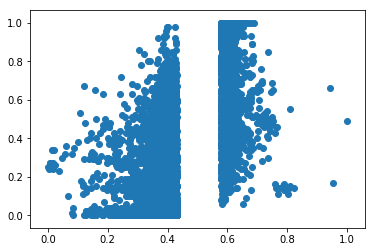

In [74]:
plt.scatter(etfile_test.train.values['zscore'],probs[:,1])

Raw data loaded.
Data Normalized.
(28454,) (28454,)


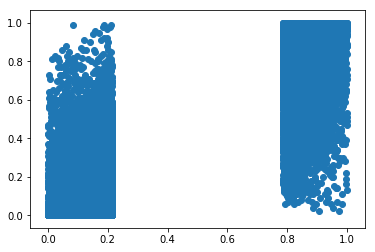

In [77]:
gtfile_test = load_data_pandas(gt_filepath,exclude = ['cpgName_split'],test_size=0)
probs = classifier_ranfor.predict_proba(gtfile_test.train.values[[col for col in gtfile_test.train.values.columns if col not in ['cpgName','direction','zscore']]])
print(gtfile_test.train.values['zscore'].shape,probs[:,0].shape)
plt.scatter(gtfile_test.train.values['zscore'],probs[:,1])

In [82]:
conf = []
for i in range(probs.shape[0]):
    if probs[i][0] >0.5:
        conf.append(probs[0])
    else:
        conf.append(probs[1])